In [1]:
import zipfile, os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


local_zip = '/content/Natural.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') 
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
base_dir ='/content/data/natural_images'

In [3]:
os.listdir('/content/data/natural_images')

['motorbike', 'fruit', 'dog', 'airplane', 'cat', 'car', 'person', 'flower']

In [4]:
print('total airplane : ', len(os.listdir('/content/data/natural_images/airplane')))
print('total car : ', len(os.listdir('/content/data/natural_images/car')))
print('total cat : ', len(os.listdir('/content/data/natural_images/cat')))
print('total flower : ', len(os.listdir('/content/data/natural_images/flower')))
print('total fruit : ', len(os.listdir('/content/data/natural_images/fruit')))
print('total motorbike : ', len(os.listdir('/content/data/natural_images/motorbike')))
print('total person : ', len(os.listdir('/content/data/natural_images/person')))



total airplane :  727
total car :  968
total cat :  885
total flower :  843
total fruit :  1000
total motorbike :  788
total person :  986


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode ='nearest',
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode ='nearest',
    validation_split = 0.2
)

In [6]:

seed = 1

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150), 
    shuffle = True,
    subset='training',
    class_mode = 'categorical',
    seed=seed
)

validation_generator = test_datagen.flow_from_directory(
    base_dir,
    shuffle = True,
    target_size=(150, 150), 
    subset = 'validation',
    class_mode = 'categorical',
    seed=seed
)

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='softmax'),
])

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
     if(logs.get('accuracy') > 0.80 and logs.get('val_accuracy') > 0.80):
      print('\n Akurasi telah mencapai > 80%')
      self.model.stop_training = True
callbacks = myCallback()

In [9]:
hist = model.fit(
      train_generator,
      steps_per_epoch = 25, 
      epochs = 100,
      validation_data = validation_generator,
      validation_steps = 5,
      batch_size=64,
      callbacks=[callbacks],
      verbose = 2)

Epoch 1/100
25/25 - 117s - loss: 1.9995 - accuracy: 0.1975 - val_loss: 1.6852 - val_accuracy: 0.3812
Epoch 2/100
25/25 - 108s - loss: 1.5903 - accuracy: 0.3893 - val_loss: 1.3184 - val_accuracy: 0.5188
Epoch 3/100
25/25 - 111s - loss: 1.1616 - accuracy: 0.5800 - val_loss: 1.0116 - val_accuracy: 0.6812
Epoch 4/100
25/25 - 111s - loss: 0.8806 - accuracy: 0.6938 - val_loss: 0.6824 - val_accuracy: 0.7312
Epoch 5/100
25/25 - 110s - loss: 0.7065 - accuracy: 0.7550 - val_loss: 0.6974 - val_accuracy: 0.7563
Epoch 6/100
25/25 - 110s - loss: 0.6548 - accuracy: 0.7688 - val_loss: 0.9929 - val_accuracy: 0.6875
Epoch 7/100
25/25 - 110s - loss: 0.6560 - accuracy: 0.7675 - val_loss: 0.7030 - val_accuracy: 0.7688
Epoch 8/100
25/25 - 110s - loss: 0.6788 - accuracy: 0.7500 - val_loss: 0.4602 - val_accuracy: 0.8375
Epoch 9/100
25/25 - 109s - loss: 0.5612 - accuracy: 0.8138 - val_loss: 0.6776 - val_accuracy: 0.7250
Epoch 10/100
25/25 - 110s - loss: 0.5529 - accuracy: 0.7900 - val_loss: 0.5254 - val_accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


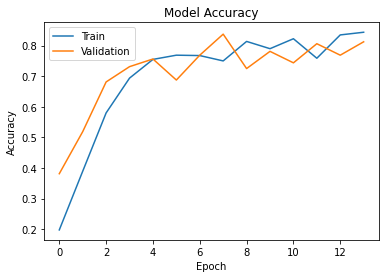

In [10]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='bottom right')
plt.show()

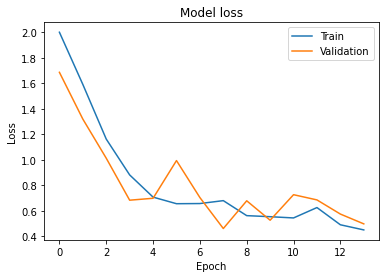

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpdhf2us66/assets


In [13]:
with tf.io.gfile.GFile('animal.tflite', 'wb') as f:
  f.write(tflite_model)